# Cross-Regional Communication Analysis of Steinmetz Dataset

This notebook analyzes interactions between brain regions, including:
1. Inter-regional spike correlations
2. LFP coherence between regions
3. Information flow analysis
4. Region-specific population dynamics
5. Task-dependent connectivity

In [7]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler
from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer

# Set plotting style
#plt.style.use('seaborn')
sns.set_context("talk")

## 1. Data Loading and Preparation

In [8]:
# Initialize data loader and load session
loader = SteinmetzDataLoader()
loader.download_data()
session_data = loader.load_session(11)  # Using session 11 as an example

# Initialize neural analyzer
analyzer = NeuralAnalyzer()

print("Available brain regions:", np.unique(session_data['brain_area_lfp']))

Available brain regions: ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp']


## 2. Inter-regional Spike Correlations

In [18]:
def compute_region_correlations(spikes, brain_regions, time_window=(-0.5, 0.5), bin_size=0.01):
    """Compute correlations between neurons from different regions."""
    unique_regions = np.unique(brain_regions)
    n_regions = len(unique_regions)
    correlation_matrix = np.zeros((n_regions, n_regions))
    
    # Compute firing rates
    time_bins = np.arange(time_window[0], time_window[1] + bin_size, bin_size)
    firing_rates = loader.compute_firing_rates(spikes, time_bins)
    
    # Compute correlations between regions
    for i, region1 in enumerate(unique_regions):
        neurons1 = np.where(brain_regions == region1)[0]
        rates1 = firing_rates[neurons1].mean(axis=0) if len(neurons1) > 0 else np.zeros_like(time_bins[:-1])
        
        for j, region2 in enumerate(unique_regions):
            neurons2 = np.where(brain_regions == region2)[0]
            rates2 = firing_rates[neurons2].mean(axis=0) if len(neurons2) > 0 else np.zeros_like(time_bins[:-1])
            
            if len(neurons1) > 0 and len(neurons2) > 0:
                correlation_matrix[i, j], _ = stats.pearsonr(rates1, rates2)
            else:
                correlation_matrix[i, j] = np.nan
    
    return correlation_matrix, unique_regions

# Use actual brain regions from the data
corr_matrix, regions = compute_region_correlations(session_data['spikes'], session_data['brain_area_lfp'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=regions, yticklabels=regions,
            cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Inter-regional Spike Correlations')
plt.show()

ValueError: Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.

## 3. LFP Coherence Analysis

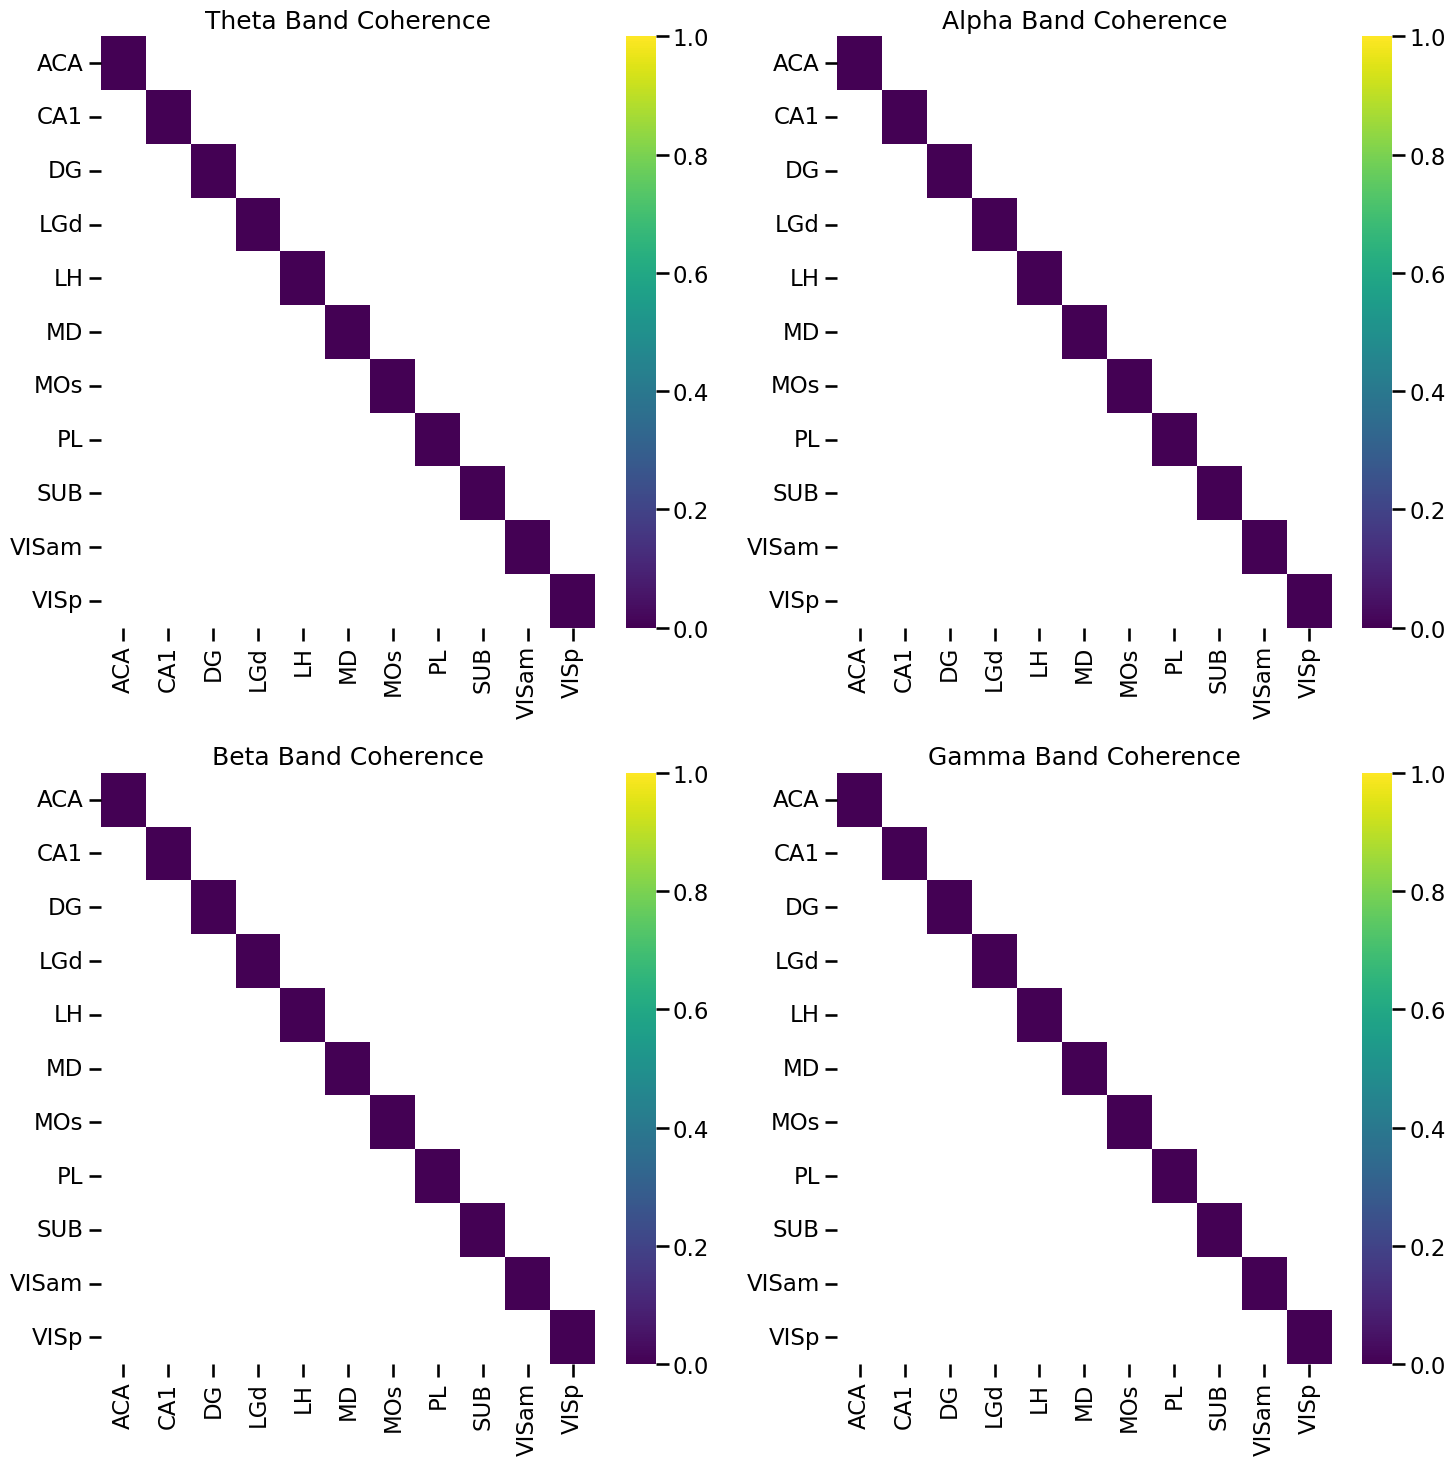

In [17]:
def compute_frequency_band_coherence(lfp1, lfp2, band_range=(4, 8), fs=100):
    """Compute coherence in specific frequency band (e.g., theta: 4-8 Hz)."""
    if np.isnan(lfp1).any() or np.isnan(lfp2).any():
        return np.nan
    
    f, Cxy = signal.coherence(lfp1, lfp2, fs=fs, nperseg=min(256, len(lfp1)))
    band_mask = (f >= band_range[0]) & (f <= band_range[1])
    
    if np.any(band_mask):
        return np.mean(Cxy[band_mask])
    else:
        return np.nan

# Define frequency bands
bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 80)
}

# Compute coherence for each band between regions
unique_areas = np.unique(session_data['brain_area_lfp'])
n_areas = len(unique_areas)
band_coherence = {band: np.zeros((n_areas, n_areas)) for band in bands}

for band_name, freq_range in bands.items():
    for i, area1 in enumerate(unique_areas):
        for j, area2 in enumerate(unique_areas):
            if i != j:
                # Get LFP from both regions
                lfp1_idx = session_data['brain_area_lfp'] == area1
                lfp2_idx = session_data['brain_area_lfp'] == area2
                
                if np.any(lfp1_idx) and np.any(lfp2_idx):
                    lfp1 = np.mean(session_data['lfp'][:, lfp1_idx], axis=1)
                    lfp2 = np.mean(session_data['lfp'][:, lfp2_idx], axis=1)
                    
                    # Compute coherence
                    band_coherence[band_name][i, j] = compute_frequency_band_coherence(
                        lfp1, lfp2, freq_range
                    )
                else:
                    band_coherence[band_name][i, j] = np.nan

# Plot coherence matrices for each frequency band
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for i, (band_name, coherence) in enumerate(band_coherence.items()):
    sns.heatmap(coherence, xticklabels=unique_areas, yticklabels=unique_areas,
                cmap='viridis', vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(f'{band_name.capitalize()} Band Coherence')

plt.tight_layout()
plt.show()

## 4. Information Flow Analysis

/Users/shibanibudhraja/Downloads/Neuromatch/venv/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/shibanibudhraja/Downloads/Neuromatch/venv/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


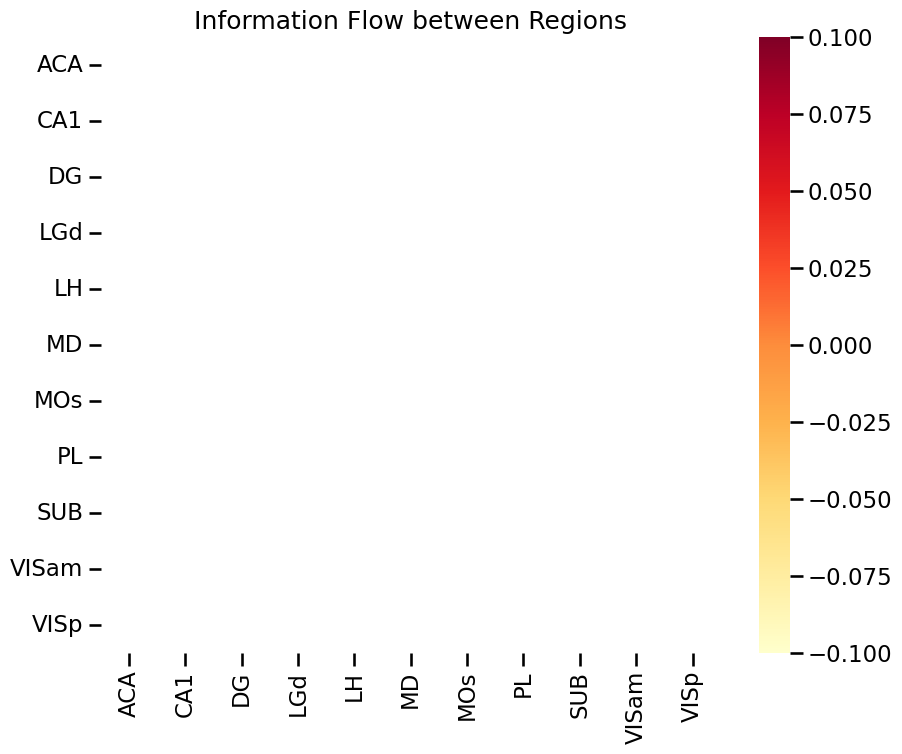

In [19]:
def compute_granger_causality(signal1, signal2, max_lag=5):
    """Compute Granger causality between two signals."""
    from statsmodels.tsa.stattools import grangercausalitytests
    
    # Check for NaN values
    if np.isnan(signal1).any() or np.isnan(signal2).any():
        return np.nan, np.nan
    
    # Prepare data - ensure we have a 2D array
    data = np.column_stack((signal1, signal2))
    
    try:
        # Test Granger causality in both directions
        gc_results_1to2 = {}
        gc_results_2to1 = {}
        
        for lag in range(1, max_lag + 1):
            # 1 -> 2
            try:
                result = grangercausalitytests(data, maxlag=lag, verbose=False)
                gc_results_1to2[lag] = result[lag][0]['ssr_chi2test'][1]
            except:
                gc_results_1to2[lag] = np.nan
                
            # 2 -> 1
            try:
                result = grangercausalitytests(np.column_stack((signal2, signal1)), maxlag=lag, verbose=False)
                gc_results_2to1[lag] = result[lag][0]['ssr_chi2test'][1]
            except:
                gc_results_2to1[lag] = np.nan
        
        # Extract p-values
        min_p_1to2 = min([p for p in gc_results_1to2.values() if not np.isnan(p)], default=np.nan)
        min_p_2to1 = min([p for p in gc_results_2to1.values() if not np.isnan(p)], default=np.nan)
        
        return min_p_1to2, min_p_2to1
    except Exception as e:
        # If any error occurs, return NaN
        return np.nan, np.nan

# Compute Granger causality between regions
flow_matrix = np.zeros((n_areas, n_areas))
flow_matrix.fill(np.nan)

for i, area1 in enumerate(unique_areas):
    for j, area2 in enumerate(unique_areas):
        if i != j:
            # Get LFP from both regions
            lfp1_idx = session_data['brain_area_lfp'] == area1
            lfp2_idx = session_data['brain_area_lfp'] == area2
            
            if np.any(lfp1_idx) and np.any(lfp2_idx):
                lfp1 = np.mean(session_data['lfp'][:, lfp1_idx], axis=1)
                lfp2 = np.mean(session_data['lfp'][:, lfp2_idx], axis=1)
                
                # Make the signals stationary if needed
                lfp1 = np.diff(lfp1)
                lfp2 = np.diff(lfp2)
                
                gc_1to2, gc_2to1 = compute_granger_causality(lfp1, lfp2)
                if not np.isnan(gc_1to2):
                    flow_matrix[i, j] = -np.log10(gc_1to2) if gc_1to2 > 0 else np.nan

# Plot information flow matrix
plt.figure(figsize=(10, 8))
sns.heatmap(flow_matrix, xticklabels=unique_areas, yticklabels=unique_areas,
            cmap='YlOrRd')
plt.title('Information Flow between Regions')
plt.show()

## 5. Task-Dependent Connectivity

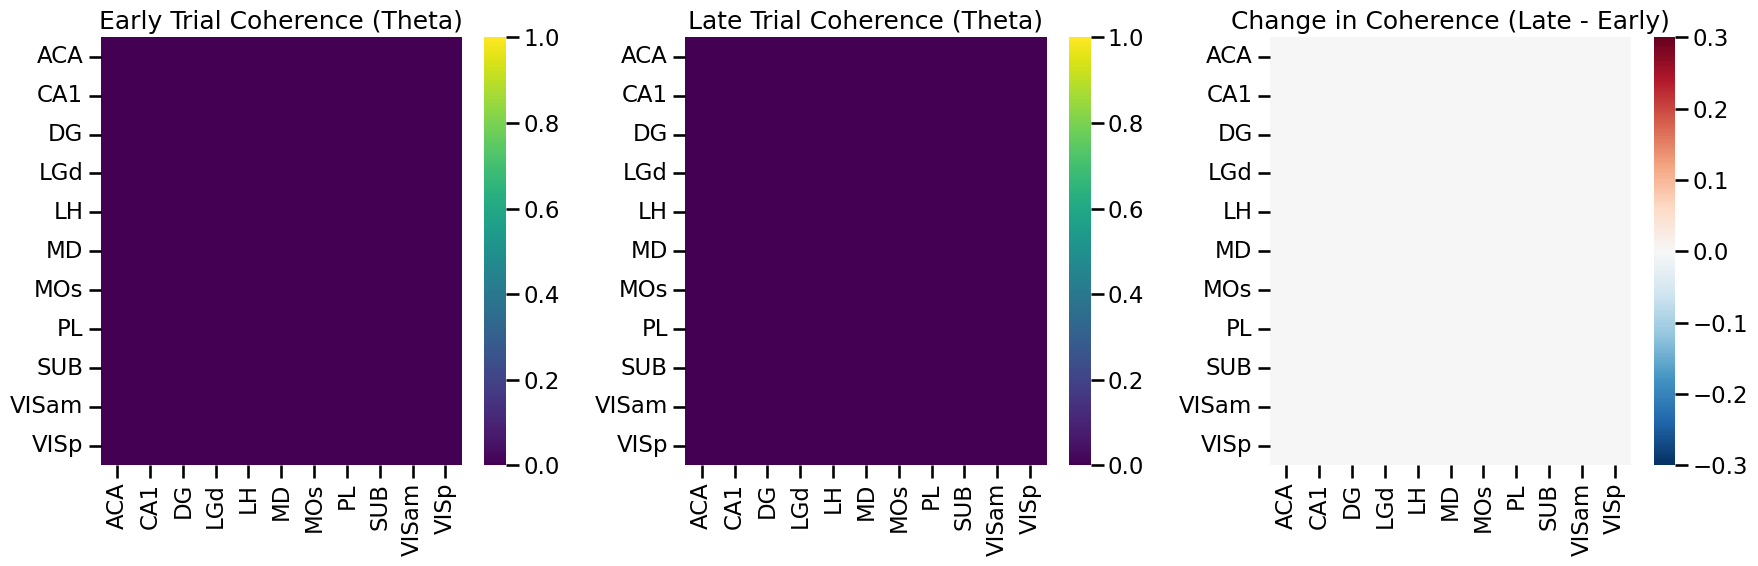

In [20]:
def compute_coherence_task_dependent(session_data, freq_band=(4, 8), trial_split_point=0.5):
    """Compare coherence during early vs late trials to assess task-dependent connectivity."""
    # Get brain regions
    brain_areas = np.unique(session_data['brain_area_lfp'])
    n_areas = len(brain_areas)
    
    # Split trials into early and late
    n_trials = session_data['lfp'].shape[0]
    split_idx = int(n_trials * trial_split_point)
    
    early_data = session_data['lfp'][:split_idx, :]
    late_data = session_data['lfp'][split_idx:, :]
    
    # Initialize matrices
    early_coherence = np.zeros((n_areas, n_areas))
    late_coherence = np.zeros((n_areas, n_areas))
    
    # Calculate coherence for each region pair
    for i, area1 in enumerate(brain_areas):
        for j, area2 in enumerate(brain_areas):
            if i != j:
                # Get indices for each region
                idx1 = session_data['brain_area_lfp'] == area1
                idx2 = session_data['brain_area_lfp'] == area2
                
                if np.any(idx1) and np.any(idx2):
                    # Early trials
                    try:
                        lfp1_early = np.mean(early_data[:, idx1], axis=1)
                        lfp2_early = np.mean(early_data[:, idx2], axis=1)
                        early_coherence[i, j] = compute_frequency_band_coherence(lfp1_early, lfp2_early, freq_band)
                    except:
                        early_coherence[i, j] = np.nan
                    
                    # Late trials
                    try:
                        lfp1_late = np.mean(late_data[:, idx1], axis=1)
                        lfp2_late = np.mean(late_data[:, idx2], axis=1)
                        late_coherence[i, j] = compute_frequency_band_coherence(lfp1_late, lfp2_late, freq_band)
                    except:
                        late_coherence[i, j] = np.nan
    
    # Calculate difference in coherence
    diff_coherence = late_coherence - early_coherence
    
    return early_coherence, late_coherence, diff_coherence, brain_areas

# Compute task-dependent connectivity in theta band
early_coh, late_coh, diff_coh, regions = compute_coherence_task_dependent(
    session_data, freq_band=(4, 8)
)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(early_coh, ax=axes[0], cmap='viridis', vmin=0, vmax=1, 
            xticklabels=regions, yticklabels=regions)
axes[0].set_title('Early Trial Coherence (Theta)')

sns.heatmap(late_coh, ax=axes[1], cmap='viridis', vmin=0, vmax=1,
            xticklabels=regions, yticklabels=regions)
axes[1].set_title('Late Trial Coherence (Theta)')

sns.heatmap(diff_coh, ax=axes[2], cmap='RdBu_r', center=0, vmin=-0.3, vmax=0.3,
            xticklabels=regions, yticklabels=regions)
axes[2].set_title('Change in Coherence (Late - Early)')

plt.tight_layout()
plt.show()